# Solução Numérica da Equação de Laplace
***Mariana Jó (7241072)***

*Eletromagnetismo I, 2017*
___

A Equação de Laplace para o potencial elétrico é dada por:
$$
\nabla^2\varphi = 0
$$

e podemos determinar $\varphi$ uma vez que tivermos as condições de contorno para o problema.

Podemos encontrar esta solução numericamente utilizando um Método de Diferenças Finitas, onde a solução é aproximada pelas derivadas. *(checar referência)*.

Neste trabalho iremos propor dois métodos diferentes: o Método de Jacobi e o Método de Gauss-Seidel. Ambos os métodos são iterativos e se convergem para a solução a cada iteração, sendo que o Método de Gauss-Seidel é mais eficiente. Iremos, portanto, analisar a eficiência de ambos, comparando-os.

Os seguintes passos serão seguidos a fim de encontrar a solução da Equação de Laplace:

1. Definição da geometria
1. Discretização do domínio
1. Especificação das condições de contorno
1. "Chute" inicial de valores arbitrários para o interior da região
1. Aplicação os métodos que nos dão a solução
1. Análise das convergências e erros

In [58]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
%matplotlib inline

## 0. Definição de funções auxiliares

Primeiramente, vamos definir algumas funções que irão nos auxiliar na solução, tornando assim a leitura mais direta, sem a necessidade de pedaços código desconexos durante o acompanhamento da solução.

Funções para gráficos:

In [59]:
def plot_potential(matrix):
    """
    Plota o gráfico para o potencial, utilizando um colormap.
    
    Parâmetros
    ----------
    
    matrix : numpy 2D array    
    """
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    mappable = axes.imshow(matrix, cmap=cm.RdYlGn, interpolation='gaussian', origin='lower')
    fig.colorbar(mappable, ax=axes)
    
    
def plot_errors(errors):
    """
    Plota gráfico dos erros de um método por iteração.
    
    Parâmetros
    ----------
    
    errors : list
        Lista dos erros para cada iteração
    """
    n = len(errors)
    
    df = pd.DataFrame(data={"errors": errors, "iterations": np.linspace(1, n, n)})
    sns.lmplot(x="iterations", y="errors", data=df, fit_reg=False)

## 1. Definição da geometria e discretização do domínio

*(descrever a geometria)*

O problema possui simetria em $z$ e, portanto, podemos considerá-lo um problema com dependência apenas em $x$ e $y$.
A caixa possui as dimensões $(x, y) = (a, b)$, onde $a=10$ e $b=10$.

Podemos escolher diversas formas de discretização $h$ e analisar os diferentes resultados para todas elas. Utilizaremos o sistema de coordenadas cartesianas, com o retângulo no plano $xy$, onde $0 \leq x \leq a$ e $0 \leq y \leq b$:

In [60]:
a, b = 10, 10
h = 6
x = np.linspace(0, a, h)
y = np.linspace(0, b, h)

## 2. Métodos de solução da Equação de Laplace

### Método de Jacobi

In [61]:
def jacobi_method(matrix, h, tol=(10**(-3))):
    """
    Implementação do Método Iterativo de Jacobi. O método para quanto o erro err é menor do que a tolerância tol.
    
    Parâmetros
    ----------
    
    matrix : numpy 2D-array
        Array com os valores iniciais do problema
    h : int
        Número de divisões da discretização da geometria
    tol : float
        Tolerância de erro, a ser usada como critério de parada do método. Default: 10e-3
        
    Retorna
    -------
    dict : 
        Um dicionário com a solução do método como um numpy 2D array e uma lista dos os erros para cada iteração.
    """
    
    err = 1
    errors = []

    j = matrix.copy()
    
    while err > tol:
        prev = j.copy()
        for r, c in itertools.product(range(1, h-1), range(1, h-1)):
            adj = [prev[r-1, c], prev[r+1, c], prev[r, c-1], prev[r, c+1]]
            j[r, c] = np.mean(adj)
        err = np.linalg.norm(j-prev)/np.linalg.norm(j)
        errors.append(err)
    
    return {"solution":j, "errors": errors}

### Método de Gauss-Seidel

Explicar método e a diferença dele pro Jacobi

Para $N=10$:

In [62]:
def gauss_method(matrix, h, tol=(10**(-3))):
    """
    Implementação do Método Iterativo de Gauss-Seidel. O método para quanto o erro err é menor do que a tolerância tol.
    
    Parâmetros
    ----------
    
    matrix : numpy 2D-array
        Array com os valores iniciais do problema
    h : int
        Número de divisões da discretização da geometria
    tol : float
        Tolerância de erro, a ser usada como critério de parada do método. Default: 10e-3
        
    Retorna
    -------
    dict : 
        Um dicionário com a solução do método como um numpy 2D array e uma lista dos os erros para cada iteração.
    """
    
    err = 1
    errors = []
    
    j = matrix.copy()
    
    while err > tol:
        prev = j.copy()
        for r, c in itertools.product(range(1, h-1), range(1, h-1)):
            adj = [j[r-1, c], j[r+1, c], j[r, c-1], j[r, c+1]]
            j[r, c] = np.mean(adj)
        err = np.linalg.norm(j-prev)/np.linalg.norm(j)
        errors.append(err)
    
    return {"solution": j, "errors": errors}

## 3. Especificação das condicões de contorno

Primeiramente definimos as condições de contorno nas bordas do retângulo:

1. $V(0,y)=75$
1. $V(a,y)=50$
1. $V(x,0)=800$
1. $V(x,b)=1000$

In [70]:
bc = {"top": 1000,
      "bottom": -500,
      "left": 800,
      "right":50
     }

## 4. "Chute" inicial de valores arbitrários para o interior da região

Fazemos, então, com que os valores da região interna ao retângulo sejam a média dos valores nas bordas.

Os valores das quinas sobrescrevem uns aos outros durante o procedimento anterior. Dessa maneira, fazemos com que as quinas sejam a média dos valores das bordas da quina em questão.

In [90]:
# z = np.ones(shape=(h, h))*np.mean(list(bc.values()))
z = np.zeros(shape=(h, h))

# Adicionando as condições de contorno nas bordas
z[0:-1,0] = bc["left"]
z[0:,-1] = bc["right"]
z[0,1:-1] = bc["bottom"]
z[-1,0:-1] = bc["top"]
# z[0,0] = np.mean([bc["top"], bc["left"]])
# z[0,-1] = np.mean([bc["top"], bc["right"]])
# z[-1,0] = np.mean([bc["bottom"], bc["left"]])
# z[-1,-1] = np.mean([bc["bottom"], bc["right"]])

Assim, temos nosso retângulo original, com os valores determinados nas bordas e estimados no interior:

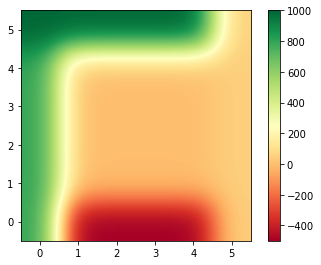

In [91]:
plot_potential(z)

## 5. Aplicação e análise dos métodos


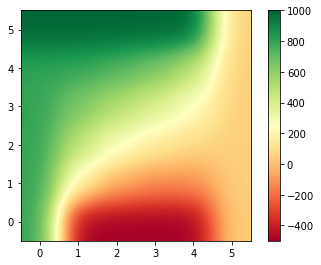

In [92]:
jacobi = jacobi_method(z, h)
plot_potential(jacobi["solution"])

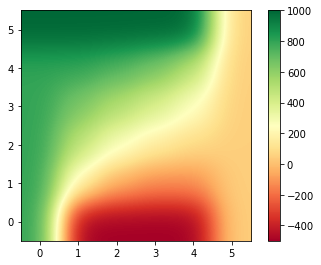

In [93]:
gauss = gauss_method(z, h)
plot_potential(gauss["solution"])

### Análise de erros e convergência

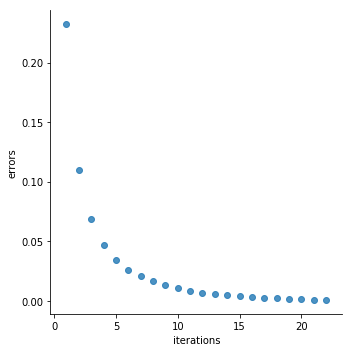

In [94]:
plot_errors(jacobi["errors"])

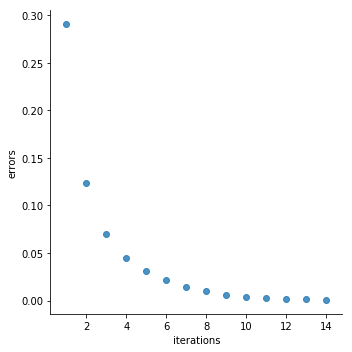

In [95]:
plot_errors(gauss["errors"])